Submission 2 Belajar Pengembangan Machine Learning - Time Series

Nadya Novalina

Import Library

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

Connect Google Drive / Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/GlobalLandTemperaturesByCity.csv' 

Ubah dataset menjadi dataframe dengan fungsi read_csv()

In [4]:
data_train = pd.read_csv(path)
data_train.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


Mengambil data temperatur Indonesia



In [5]:
data_train = data_train.loc[data_train['Country'].isin(['Indonesia'])]
data_train

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
84977,1825-01-01,26.193,2.113,Adiwerna,Indonesia,7.23S,109.46E
84978,1825-02-01,25.618,1.351,Adiwerna,Indonesia,7.23S,109.46E
84979,1825-03-01,25.970,1.876,Adiwerna,Indonesia,7.23S,109.46E
84980,1825-04-01,26.687,2.039,Adiwerna,Indonesia,7.23S,109.46E
84981,1825-05-01,26.148,1.090,Adiwerna,Indonesia,7.23S,109.46E
...,...,...,...,...,...,...,...
8427762,2013-05-01,27.125,0.193,Yogyakarta,Indonesia,7.23S,111.08E
8427763,2013-06-01,26.909,0.538,Yogyakarta,Indonesia,7.23S,111.08E
8427764,2013-07-01,26.377,0.376,Yogyakarta,Indonesia,7.23S,111.08E
8427765,2013-08-01,26.950,0.473,Yogyakarta,Indonesia,7.23S,111.08E


Cek data hilang

In [6]:
data_train.isnull().sum()

dt                                   0
AverageTemperature               49960
AverageTemperatureUncertainty    49960
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

Drop data yg memiliki nilai null

In [7]:
data_train.dropna(subset=['AverageTemperature'],inplace=True)
data_train.dropna(subset=['AverageTemperatureUncertainty'],inplace=True)
data_train.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

Drop column yang tidak dibutuhkan

In [8]:
data_train.drop(['AverageTemperatureUncertainty','City', 'Latitude', 'Longitude'], axis=1, inplace=True)
data_train

,dt,AverageTemperature,Country
84977,1825-01-01,26.193,Indonesia
84978,1825-02-01,25.618,Indonesia
84979,1825-03-01,25.970,Indonesia
84980,1825-04-01,26.687,Indonesia
84981,1825-05-01,26.148,Indonesia
...,...,...,...
8427761,2013-04-01,27.047,Indonesia
8427762,2013-05-01,27.125,Indonesia
8427763,2013-06-01,26.909,Indonesia
8427764,2013-07-01,26.377,Indonesia


Plot data

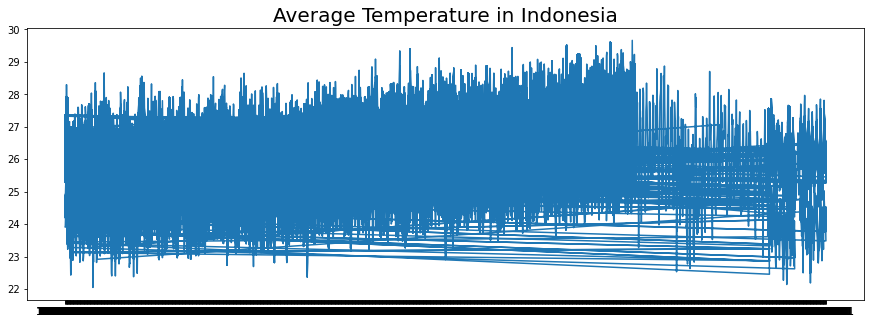

In [10]:
dates = data_train['dt'].values
temp  = data_train['AverageTemperature'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Average Temperature in Indonesia',
          fontsize=20);

Membagi Dataset

In [11]:
x_train, x_val, y_train, y_val = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

Rincian Dataset

In [12]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_val))

Total Data Train :  218636
Total Data Validation :  54659


Merubah data agar dapat diterima model

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Model

In [14]:
tf.keras.backend.set_floatx('float64')

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_val, window_size=60, batch_size=100, shuffle_buffer=1000)

model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

MAE

In [15]:
min_MAE = (temp.max() - temp.min()) * 10/100
min_MAE

0.7617999999999998

Callback

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<min_MAE):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

Proses Training

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])


Epoch 1/100
      6/Unknown - 8s 113ms/step - loss: 25.1212 - mae: 25.6212WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0468s vs `on_train_batch_end` time: 0.0727s). Check your callbacks.
2186/2186 [==============================] - 255s 114ms/step - loss: 2.9956 - mae: 3.3603 - val_loss: 0.4085 - val_mae: 0.7721
Epoch 2/100
2186/2186 [==============================] - 248s 113ms/step - loss: 0.3178 - mae: 0.6594 - val_loss: 0.4077 - val_mae: 0.7707

MAE dari model < 10% skala data


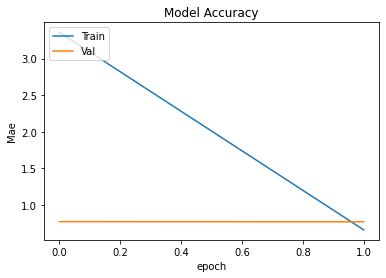

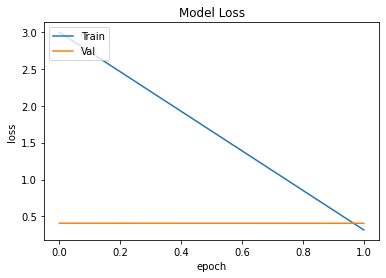

In [18]:
# Model Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Dataset : https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv